In [1]:
%load_ext autoreload
%autoreload 2
import cv2
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import plotly.graph_objects as go

from sklearn.cluster import DBSCAN

# Hack the path for now, deal with this later
cwd = '/teamspace/studios/this_studio/letsdoit'
if (cwd not in sys.path):
    sys.path.append(cwd)
sys.path.append(os.path.dirname(cwd))

from masks_finder import MasksFinder
from masks_matcher import MasksMatcher
from clip_retriever import ClipRetriever
from dataloader.dataloader import DataLoader
from object_scorer import ObjectScorer
from utils.object_instance import ObjectInstance, initialize_object_instances

import GroundingDINO.groundingdino.datasets.transforms as T


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Paths

In [2]:
path_dataset = '/teamspace/studios/this_studio/datasets'

### Initialize things

In [3]:
loader = DataLoader(path_dataset, split='dev')
retriever = ClipRetriever()
masks_finder = MasksFinder()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])
<All keys matched successfully>


In [4]:
ASSET_TYPE = 'wide'

### Functions

In [5]:
def select_ids(array, ids):
    return [array[idx] for idx in ids]

## Pipeline

In [6]:
visit_ids = loader.visit_ids
video_ids = loader.get_video_ids(visit_ids[0])

visit_id = visit_ids[0]
video_id = video_ids[0]

In [15]:
images, image_paths, intrinsics, poses, orientations = loader.get_images(visit_id, video_id, asset_type=ASSET_TYPE, sample_freq=1)
depths, depth_paths, _, _, _ = loader.get_depths(visit_id, video_id, asset_type=ASSET_TYPE, sample_freq=1)

Loading rgb frames from visit 420683 and video 42445132:  23%|██▎       | 37/159 [00:01<00:06, 17.64it/s]

Loading rgb frames from visit 420683 and video 42445132: 100%|██████████| 159/159 [00:07<00:00, 20.66it/s]
Loading depth frames from visit 420683 and video 42445132: 100%|██████████| 159/159 [00:05<00:00, 31.57it/s]


In [18]:
retriever.generate_image_features(images)

In [23]:
retriever.image_features[0].shape

torch.Size([512])

In [54]:
# For an object, get a list of corresponding ObjectInstances
object = 'drawer'
best_indices = retriever.retrieve_best_images_for_object(object, topk=10, max_similarity_thresh=0.95)

tensor(0.9478, grad_fn=<MaxBackward1>)
tensor(0.9813, grad_fn=<MaxBackward1>)
tensor(0.9740, grad_fn=<MaxBackward1>)
tensor(0.9459, grad_fn=<MaxBackward1>)
tensor(0.9448, grad_fn=<MaxBackward1>)
tensor(0.9718, grad_fn=<MaxBackward1>)
tensor(0.9824, grad_fn=<MaxBackward1>)
tensor(0.9769, grad_fn=<MaxBackward1>)
tensor(0.9677, grad_fn=<MaxBackward1>)
tensor(0.8786, grad_fn=<MaxBackward1>)
tensor(0.9718, grad_fn=<MaxBackward1>)
tensor(0.9786, grad_fn=<MaxBackward1>)
tensor(0.9649, grad_fn=<MaxBackward1>)
tensor(0.9656, grad_fn=<MaxBackward1>)
tensor(0.9495, grad_fn=<MaxBackward1>)
tensor(0.9896, grad_fn=<MaxBackward1>)
tensor(0.9648, grad_fn=<MaxBackward1>)
tensor(0.9788, grad_fn=<MaxBackward1>)
tensor(0.9703, grad_fn=<MaxBackward1>)
tensor(0.9645, grad_fn=<MaxBackward1>)
tensor(0.9518, grad_fn=<MaxBackward1>)
tensor(0.9730, grad_fn=<MaxBackward1>)
tensor(0.9319, grad_fn=<MaxBackward1>)
tensor(0.9584, grad_fn=<MaxBackward1>)
tensor(0.9786, grad_fn=<MaxBackward1>)
tensor(0.9494, grad_fn=<M

In [55]:
best_images = select_ids(images, best_indices)
best_image_paths = select_ids(image_paths, best_indices)
best_intrinsics = select_ids(intrinsics, best_indices)
best_poses = select_ids(poses, best_indices)
best_orientations = select_ids(orientations, best_indices)
best_depths = select_ids(depths, best_indices)
best_depth_paths = select_ids(depth_paths, best_indices)

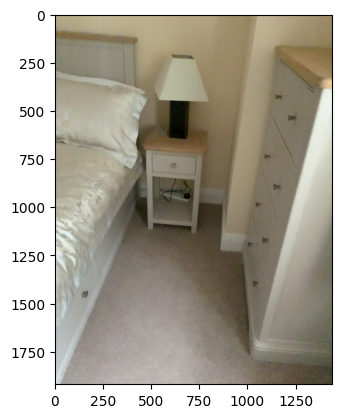

In [59]:
plt.imshow(best_images[3])

In [36]:
image_ids, masks, bboxes, confidences, labels = masks_finder.get_masks_from_imgs(best_images, object)

  0%|          | 0/10 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning:

The `device` argument is deprecated and will be removed in v5 of Transformers.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning:

torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning:

None of the inputs have requires_grad=True. Gradients will be None

 10%|█         | 1/10 [00:01<00:10,  1.16s/it]

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


In [37]:
dict_object_instances = {'images': select_ids(best_images, image_ids),
                         'depths': select_ids(best_depths, image_ids),
                         'bboxes': bboxes,
                         'masks': masks,
                         'labels': labels,
                         'confidences': confidences,
                         'intrinsics': select_ids(best_intrinsics, image_ids),
                         'extrinsics': select_ids(best_poses, image_ids),
                         'orientations': select_ids(best_orientations, image_ids)}

object_instances = initialize_object_instances(**dict_object_instances)

### Masks Matching

In [38]:
centers = []


for object_instance in object_instances:
    centers.append(object_instance.center_3d.squeeze())

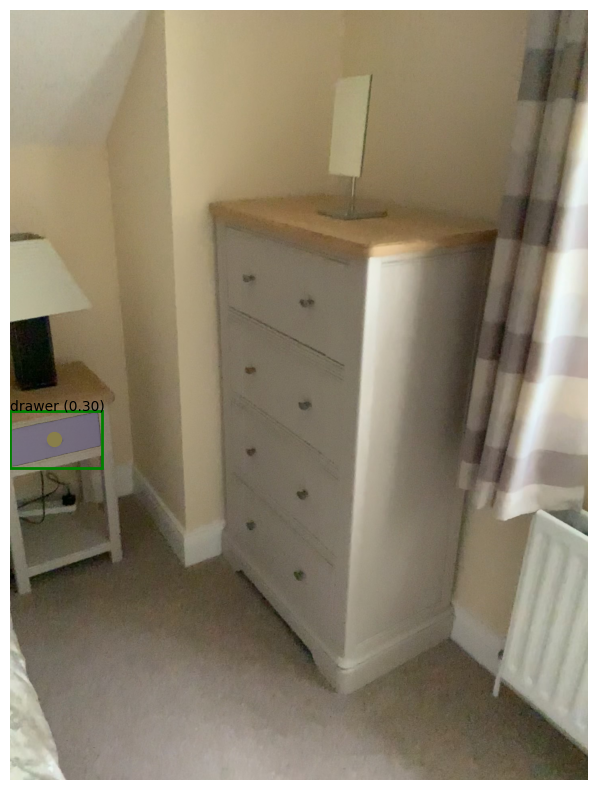

In [39]:
object_instances[7].plot_2d()

In [45]:
masks = np.hstack([ob.mask_3d[:,np.random.randint(0, ob.mask_3d.shape[1], size=1000)] for ob in select_ids(object_instances, [1, 35])])

In [43]:
masks = np.hstack([ob.mask_3d[:,np.random.randint(0, ob.mask_3d.shape[1], size=1000)] for ob in object_instances])

In [46]:
fig = go.Figure()

mask_color = np.random.rand(3,)
fig.add_trace(go.Scatter3d(
    x=masks[0, :],
    y=masks[1, :],
    z=masks[2, :],
    mode='markers',
    marker=dict(size=2, color=mask_color, opacity=0.8),
    name='Mask Points'
))

fig.update_layout(title='3D Mask and Center Point',
                scene=dict(xaxis_title='X Axis',
                            yaxis_title='Y Axis',
                            zaxis_title='Z Axis'))

fig.show()


check the extrinsics
intrinsics
depth

In [49]:
dbscan = DBSCAN(eps=0.01, min_samples=4)

In [50]:
labels = dbscan.fit_predict(masks.T)

dict_labels = {label: [] for label in np.unique(labels)}

for idx, label in enumerate(labels):
    dict_labels[label].append(idx)

In [51]:
masks.T[dict_labels[6]].shape

(20, 3)

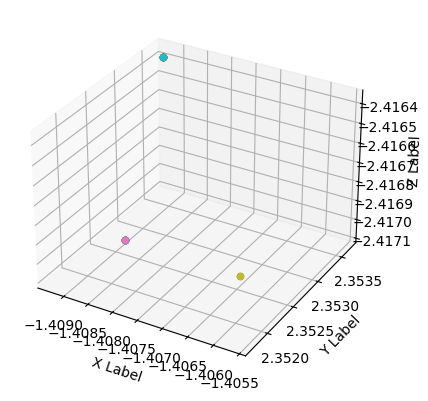

In [53]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for x, y, z in masks.T[dict_labels[3]]:
    ax.scatter(x, y, z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [34]:
object_instances[dict_labels[0][0]].plot_3d()

In [33]:
object_instances[0].center_3d

array([-0.58949391,  2.35453429, -2.08590716])